# Modulation Complexity

In [213]:
import numpy as np 
import os
import copy
from math import *
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from functools import reduce
# reading in dicom files
import pydicom
# skimage image processing packages
from skimage import measure, morphology
from skimage.morphology import ball, binary_closing
from skimage.measure import label, regionprops
# scipy linear algebra functions 
from scipy.linalg import norm
import scipy.ndimage
# ipywidgets for some interactive plots
from ipywidgets.widgets import * 
import ipywidgets as widgets
# plotly 3D interactive graphs 
import plotly
from plotly.graph_objs import *
import chart_studio.plotly as py
import nibabel
#new
#import pymedphys
import sys
import glob
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns
#To change point detection
import pandas as pd
import ruptures as rpt
# To find peacks
import plotly.graph_objects as go
import pandas as pd
from scipy.signal import find_peaks
from scipy.signal import find_peaks_cwt
from scipy.signal import peak_prominences
from scipy.signal import peak_widths

In [281]:
ds = pydicom.dcmread('datasets/dicomfiles_TB/RT_plan/RP.1PELVIS2.TB-01.dcm')
print('File Modality ->', ds.Modality)

File Modality -> RTPLAN


In [282]:
#Number of control points
N= 178
Leaf = 18

In [283]:
#LM_1[0,:]

## Extract MLC movements

In [284]:
d_1 = ds.BeamSequence[0]
ww_1= []
for m in range(1,178):
    cp_1 = d_1.ControlPointSequence[m]
    cc_1 = cp_1.BeamLimitingDevicePositionSequence[0]
    vv_1 = cc_1.LeafJawPositions
    ww_1.append(vv_1)
LM_1 = np.array(ww_1)
lm_1 = abs(LM_1)
print('lm_1-->', lm_1.shape)
#Now it is necessary to extract all the leafs that are in the field
#Creating a pandas data frame to exclude the columns (leafs) with values zeros
#Then creating new dataframes reasigning the old ones
data1= pd.DataFrame(LM_1)
data2 =data1.loc[:, (data1 != -46.4).any(axis=0)]
print('leafs moving-beam1>>', data2.shape)
F1B1 = np.array(data2.iloc[:, :18])
F1B2 = np.array(data2.iloc[:, 18:])
print('size of F1B1-->', F1B1.shape)
print('size of F1B2-->', F1B2.shape)

lm_1--> (177, 120)
leafs moving-beam1>> (177, 36)
size of F1B1--> (177, 18)
size of F1B2--> (177, 18)


In [285]:
#LM_1[0,:]

In [286]:
#F1B1[0,:]

In [287]:
#F1B2[0,:]

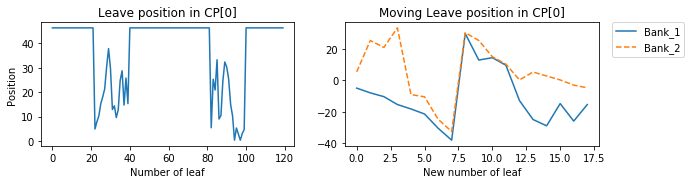

In [288]:
fig = plt.figure()
fig.set_size_inches(10, 5)
plt.subplot(2, 2, 1)
plt.plot(lm_1[0,:])
plt.title('Leave position in CP[0]')
plt.xlabel('Number of leaf')
plt.ylabel('Position')
plt.subplot(2, 2, 2)
plt.plot(F1B1[0,:], '-',label='Bank_1')
plt.plot(F1B2[0,:], '--', label='Bank_2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',  borderaxespad=0)
plt.title('Moving Leave position in CP[0]')
plt.xlabel('New number of leaf');

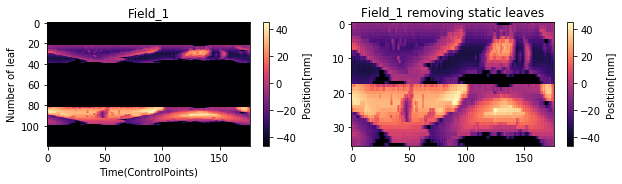

In [222]:
fig = plt.figure()
fig.set_size_inches(10, 5)
plt.subplot(2, 2, 1)
plt.imshow(LM_1.T, aspect= 'auto', cmap='magma')
cb = plt.colorbar()
cb.set_label("Position[mm]")
plt.title('Field_1')
plt.xlabel('Time(ControlPoints)')
plt.ylabel('Number of leaf')
plt.subplot(2, 2, 2)
plt.imshow(data2.T, aspect= 'auto', cmap='magma')
cb = plt.colorbar()
cb.set_label("Position[mm]")
plt.title('Field_1 removing static leaves')
plt.show();
plt.show()

## Calculating Pos_max

In [223]:
max_Pos_F1B1 = np.array([ max(F1B1[i,:]) for i in range(0,N-1)])
min_Pos_F1B1 = np.array([ min(F1B1[i,:]) for i in range(0,N-1)])
max_Pos_F1B2 = np.array([ max(F1B2[i,:]) for i in range(0,N-1)])
min_Pos_F1B2 = np.array([ min(F1B2[i,:]) for i in range(0,N-1)])
print('max_Pos_F1B1-->>', max_Pos_F1B1.shape)
print('min_Pos_F1B1-->>', min_Pos_F1B1.shape)
print('max_Pos_F1B2-->>', max_Pos_F1B2.shape)
print('min_Pos_F1B2-->>', min_Pos_F1B2.shape)
Pos_max_F1B1 = np.array(max_Pos_F1B1 - min_Pos_F1B1)
Pos_max_F1B2 = np.array(max_Pos_F1B2 - min_Pos_F1B2)
print('Pos_max_F1B1-->>', Pos_max_F1B1.shape)
print('Pos_max_F1B2-->>', Pos_max_F1B2.shape)

max_Pos_F1B1-->> (177,)
min_Pos_F1B1-->> (177,)
max_Pos_F1B2-->> (177,)
min_Pos_F1B2-->> (177,)
Pos_max_F1B1-->> (177,)
Pos_max_F1B2-->> (177,)


Text(0.5, 1.0, 'Field_1 removing static leaves')

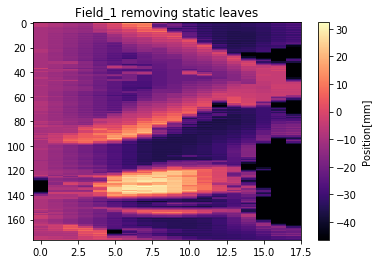

In [224]:
plt.imshow(F1B1, aspect='auto', cmap='magma')
cb = plt.colorbar()
cb.set_label("Position[mm]")
plt.title('Field_1 removing static leaves')

In [225]:
#plt.plot(F1B1[20,:])

In [226]:
# max(F1B1[20,:]) - min(F1B1[20,:])

Text(0.5, 1.0, 'Maximum Possible Change in CP or Bank_2')

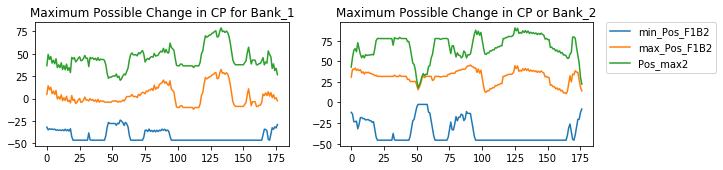

In [227]:
fig = plt.figure()
fig.set_size_inches(10, 5)
plt.subplot(2, 2, 1)
line1, =plt.plot(min_Pos_F1B1, label='min_Pos_F1B1')
line2, =plt.plot(max_Pos_F1B1, label='max_Pos_F1B1')
line3, =plt.plot(Pos_max_F1B1, label='Pos_max1')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',  borderaxespad=0)
plt.title('Maximum Possible Change in CP for Bank_1')

plt.subplot(2, 2, 2)
plt.plot(min_Pos_F1B2, label='min_Pos_F1B2')
plt.plot(max_Pos_F1B2, label='max_Pos_F1B2')
plt.plot(Pos_max_F1B2,  label='Pos_max2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',  borderaxespad=0)
plt.title('Maximum Possible Change in CP or Bank_2')

## Calculating LSV

In [228]:
#-->Absolute value of the difference of position
o1= []
u1= []
for j in range(0,N-1):
    p11= [F1B1[j,i]-F1B1[j,i+1] for i in range(0,Leaf-1)]
    p12= [F1B2[j,i]-F1B2[j,i+1] for i in range(0,Leaf-1)]
    o1.append(p11)
    u1.append(p12)
print(len(o1))
print(len(u1))
A1 = np.array(o1)
A2 = np.array(u1)
dif_F1B1 = abs(A1)
dif_F1B2 = abs(A2)
print('dif_F1B1-->>', dif_F1B1.shape)
print('dif_F1B2-->>', dif_F1B2.shape)

177
177
dif_F1B1-->> (177, 17)
dif_F1B2-->> (177, 17)


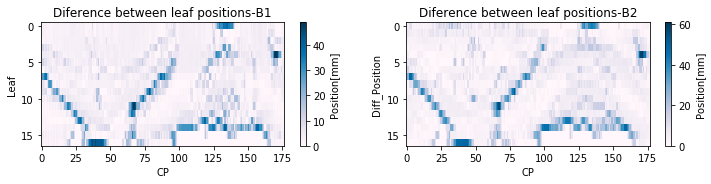

In [229]:
fig = plt.figure()
fig.set_size_inches(12, 5)
plt.subplot(2, 2, 1)
plt.imshow(dif_F1B1.T, aspect='auto', cmap='PuBu')
cb = plt.colorbar()
cb.set_label("Position[mm]")
plt.xlabel('CP')
plt.ylabel('Leaf')
plt.title('Diference between leaf positions-B1')
plt.subplot(2, 2, 2)
plt.imshow(dif_F1B2.T, aspect='auto', cmap='PuBu')
cb = plt.colorbar()
cb.set_label("Position[mm]")
plt.xlabel('CP')
plt.ylabel('Diff_Position')
plt.title('Diference between leaf positions-B2')
plt.show()

In [230]:
#Numerator of LSV
A1 = np.array([(Pos_max_F1B1[i] - dif_F1B1[i,:]) for i in range(N-1)])
A2 = np.array([(Pos_max_F1B2[i] - dif_F1B2[i,:]) for i in range(N-1)])
B1 = np.array([sum(A1[i,:]) for i in range (N-1)])
B2 = np.array([sum(A2[i,:]) for i in range (N-1)])
#Complete Operation
LSV_B1 = np.array([B1[i]/(Pos_max_F1B1[i]*(Leaf-1)) for i in range (N-1)])
LSV_B2 = np.array([B2[i]/(Pos_max_F1B2[i]*(Leaf-1)) for i in range (N-1)])
#multiplying both banks
LSV = np.multiply(LSV_B1, LSV_B2)
#LSV
#To validate, a square field along the arc must have value close to 1 since dont have much modulation and 
#the leaf sequence does not vary considrably

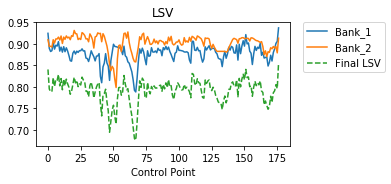

In [231]:
fig = plt.figure()
fig.set_size_inches(10, 5)
plt.subplot(2, 2, 1)
plt.plot(LSV_B1, label= 'Bank_1')
plt.plot(LSV_B2, label= 'Bank_2')
plt.plot(LSV, '--', label= 'Final LSV')
plt.xlabel('Control Point')
plt.title('LSV')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',  borderaxespad=0)
plt.show();

In [232]:
print('LSV-->>', LSV.shape)

LSV-->> (177,)


## Calculating AAV

In [233]:
#Numerator of AAV
AV1 =  np.array([F1B2[i,:] - F1B1[i,:] for i in range(N-1)])
AV2 = np.array([sum(AV1[i,:]) for i in range (N-1)])
#AV2

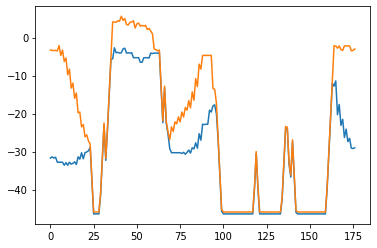

In [234]:
plt.plot(F1B1[:,15])
plt.plot(F1B2[:,15])
#plt.plot(qq)

In [235]:
#CV1 = sum(np.array([min(F1B1[:,i]) for i in range(Leaf)])) # Maximum aperture respect the axis cero ---
#CV2 = sum(np.array([max(F1B2[:,i]) for i in range(Leaf)]))
#CV3 = CV2 - CV1
CV3 = sum(np.array([max(F1B2[:,i]) - min(F1B1[:,i]) for i in range(Leaf)]))

In [236]:
AAV = AV2/CV3
#AAV

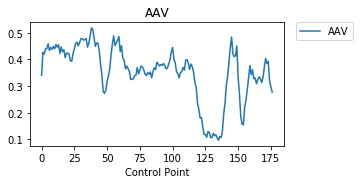

In [237]:
fig = plt.figure()
fig.set_size_inches(10, 5)
plt.subplot(2, 2, 1)
plt.plot(AAV, label= 'AAV')
plt.xlabel('Control Point')
plt.title('AAV')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',  borderaxespad=0);

## Extracting MU

In [238]:
#Total number of monitor units
T_MU = ds.FractionGroupSequence[0].ReferencedBeamSequence[0].BeamMeterset
print(T_MU)

700.257983848111


In [239]:
type(T_MU)

pydicom.valuerep.DSfloat

In [240]:
dd_1 = ds.BeamSequence[0]
www_1= []
for m in range(1,N):
    cpp_1 = dd_1.ControlPointSequence[m]
    ccc_1 = cpp_1.ReferencedDoseReferenceSequence[0]
    vvv_1 = ccc_1.CumulativeDoseReferenceCoefficient
    www_1.append(vvv_1)
mu1 = np.array(www_1)
#MU1 = mu1[:-1]
#MU1 = np.reshape(MU1, (176,1))
print('mu1--->', mu1.shape)

mu1---> (177,)


In [241]:
#adding the 1st cp with 0 MU
#a = [0]
#mu2 = np.append(a, mu1[:])
#mu2

In [242]:
#This opperation accounts the sum with the next CP
we=[]
for i in range (1,N-1):
    mu3 = abs(mu1[i-1]-mu1[i])
    we.append(mu3)
MU = np.array(we)
    

In [243]:
MU.shape

(176,)

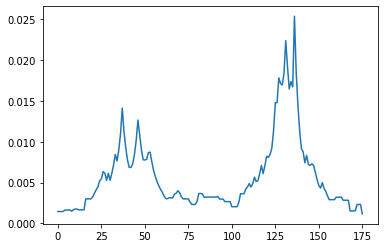

In [244]:
plt.plot((MU))

## Calculating the sum

In [245]:
#Calculate the sum
k1=[]
for i in range(0,N-2):
    LSV1= (LSV[i]+LSV[i+1])
    k1.append(LSV1)
LSV_F= (np.array(k1))
lsv = LSV_F/2
print(LSV_F.shape)

j1=[]
for i in range(0,N-2):
    AAV1= (AAV[i]+AAV[i+1])
    j1.append(AAV1)
AAV_F= np.array(j1)
aav = AAV_F/2
print(AAV_F.shape)


(176,)
(176,)


In [246]:
sum(lsv*aav*MU)

0.24207614404521424

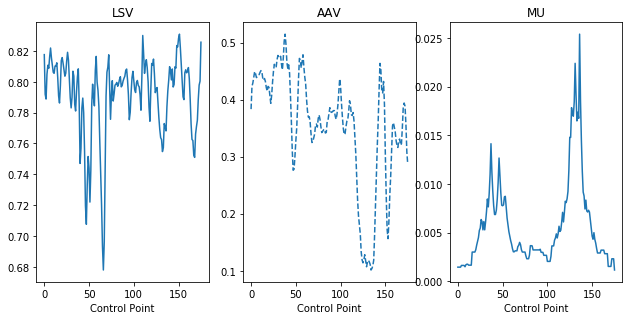

In [247]:
fig = plt.figure()
fig.set_size_inches(10.5, 10.5)
plt.subplot(2, 3, 1)
plt.plot(lsv)
#plt.plot(LSV_F/2)
plt.xlabel('Control Point')
plt.title('LSV')
plt.subplot(2, 3, 2)
plt.plot(aav, '--')
#plt.plot(AAV_F/2)
plt.xlabel('Control Point')
plt.title('AAV')
plt.subplot(2, 3, 3)
#plt.plot(mu1)
plt.plot(MU, '-')
plt.xlabel('Control Point')
plt.title('MU')
plt.show()

In [248]:
MCS_1 =sum((lsv)*(aav)*MU)
print('Modulation Complexity Score --->>', MCS_1)

Modulation Complexity Score --->> 0.24207614404521424


# Number of peaks

In [249]:
#Rememnber
#data1= pd.DataFrame(LM_1)
#data1 =data1.loc[:, (data1 != -46.4).any(axis=0)]
#F1B1 = np.array(data1.iloc[:, :18])
#F1B2 = np.array(data1.iloc[:, 18:])
#leafs moving-beam1>> (177, 36)
#size of F1B1--> (177, 18)
#size of F1B2--> (177, 18)


In [250]:
data2.shape

(177, 36)

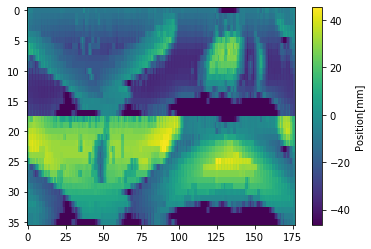

In [251]:
plt.imshow(data2.T, aspect='auto')
cb = plt.colorbar()
cb.set_label("Position[mm]");

In [252]:
tadah = np.array(data2)
rr = tadah[:,30]
rr.shape

(177,)

In [253]:
tadah.shape

(177, 36)

### For  leaf number 30 (rr = tadah[:,30])

In [254]:
peaks,__= find_peaks(rr)
prominences= peak_prominences(rr, peaks)[0]
print( peaks)
print('Length', len(peaks))
print( prominences)
print('Length', len(prominences))
print('Shape', prominences.shape)

[  1   3   5   7   9  11  13  15  17  20  28  31  36  44  47  49  51  57
  59  61  70  72  74  76  78  80  82  84  86  90  92  94  96  98 100 103
 105 109 113 116 119 122 125 127 129 132 137 140 142 145 149 151 156 159
 161 163 165 167 169 171 173 175]
Length 62
[ 3.8  0.1  0.6  0.3  0.2  1.8  1.1  1.3  1.2  1.   0.6  0.6  0.8 41.6
  0.5  1.   0.3  0.2  1.3  0.1  2.1  1.8  2.1  0.6  0.3  1.   1.3  1.8
  1.3  0.2  1.5  1.3  0.7  0.1  0.1  0.4  6.4  4.9  0.3  0.1 10.7  1.3
  1.4  0.4  0.4  1.8  1.8  1.8  0.5 14.3  0.2  1.5  9.5  0.6  0.1  1.2
  0.3  0.9  0.4  0.3  1.3  1.3]
Length 62
Shape (62,)


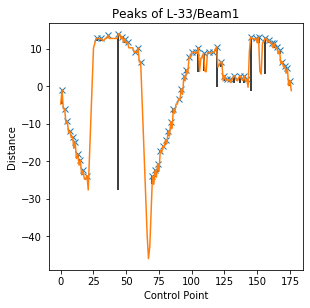

In [255]:
fig = plt.figure()
fig.set_size_inches(10, 10)

plt.subplot(2, 2, 1)
plt.plot(peaks, rr[peaks], "x")
plt.plot(rr)
contour_heights1 = rr[peaks] - prominences
plt.vlines(x=peaks, ymin=contour_heights1, ymax=rr[peaks])
plt.title('Peaks of L-33/Beam1')
plt.xlabel('Control Point')
plt.ylabel('Distance');
#plt.axis([-1, 178, 0, 100])
#plt.subplot(2, 2, 2)
#plt.plot(prominences, '-', color= 'orange')
#plt.plot(prominences, '*')
#plt.title('Prominences of L-33/Beam1')
#plt.xlabel('Number o peak')
#plt.ylabel('~Distance Traveled')
#plt.axis([-1,40, 0, 100])

In [256]:
peaks_pro,__= find_peaks(prominences)
peaks_pro.shape

(18,)

Text(0, 0.5, '~Distance Traveled')

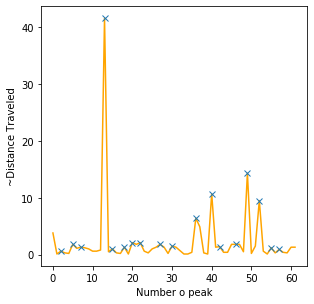

In [257]:
fig = plt.figure()
fig.set_size_inches(10.5, 10.5)

plt.subplot(2, 2, 1)
plt.plot(prominences, '-', color= 'orange')
plt.plot(peaks_pro, prominences[peaks_pro], "x")
plt.xlabel('Number o peak')
plt.ylabel('~Distance Traveled')

In [258]:
w = []
l = 18
for i in range (l*2):
    a = find_peaks(tadah[:,i])[0]
    w.append(a) 
W = np.array(w)
print(W.shape)
print(len(W[33]))

(36,)
37


In [259]:
e = []
for i in range (36):
    b= peak_prominences(tadah[:,i], W[i])[0]
    e.append(b)
E =np.array (e)
print(E.shape)
print(len(E[33]))

(36,)
37


In [260]:
Num_PEAK = [len(W[i]) for i in range (36)]
Num_PROMINENCE = np.array([len(E[i]) for i in range (Leaf*2)])
len(Num_PEAK)

36

In [261]:
AVG_Num_PEAK = np.average(Num_PEAK)
AVG_Num_PEAK
print('Aveg. Num of Peaks for Field1 --->>', AVG_Num_PEAK)

Aveg. Num of Peaks for Field1 --->> 48.72222222222222


In [262]:
AVG_Num_PROMINENCE = np.average(Num_PROMINENCE)
AVG_Num_PROMINENCE

48.72222222222222

Text(0, 0.5, 'Number of peacks')

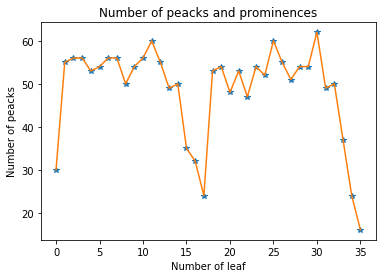

In [263]:
plt.plot(Num_PEAK, '*')
plt.plot(Num_PROMINENCE)
plt.title('Number of peacks and prominences')
plt.xlabel('Number of leaf')
plt.ylabel('Number of peacks')

In [264]:
t = []
for i in range (Leaf*2):
    a = find_peaks(E[i])[0]
    t.append(a)
Peaks_of_Pro =np.array(t)
Peaks_of_Pro.shape
P_P = np.array([len(Peaks_of_Pro[i]) for i in range (Leaf*2)])
P_P.shape
P = np.average(P_P)
P
print('Aveg. Num of Peak_Prominences for Field1 --->>', P)

Aveg. Num of Peak_Prominences for Field1 --->> 14.13888888888889


# Changing point detection

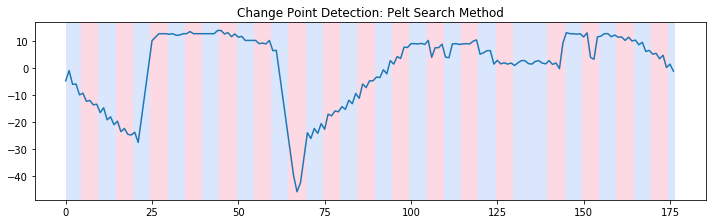

Num break 35


In [289]:
#Rupture package - PELT
model="l2"
algo1= rpt.Pelt(model=model).fit(rr)
result= algo1.predict(pen=0)
rpt.display(rr, result, figsize=(10, 3))
plt.title('Change Point Detection: Pelt Search Method')
plt.show() 
print('Num break', len(result))

In [290]:
tadah = np.array(data2)
tadah.shape

(177, 36)

In [291]:
ru=[]
model = 'l2'
for i in range(Leaf*2):
    q= rpt.Pelt(model=model).fit(tadah[:,i])
    result= q.predict(pen=0)
    ru.append(result)
A= np.array(ru)
A.shape

(36,)

In [292]:
A2 = [len(A[i]) for i in range(Leaf*2)]
Numb_Breaks = np.average(A2)
Numb_Breaks
print('Aveg. Num of changing points for Field1 --->>', Numb_Breaks)

Aveg. Num of changing points for Field1 --->> 33.94444444444444
